<div style="background-color:yellow; text-align:center; text-align:center; padding:40px;">
<h1  style="color:red;" > DI-725 : Transformers and Attention-Based Deep Networks </h1>   
<h2  style="color:red;" > Assignment - 2 </h2>
<br>
<br>
<h4  style="color:red;" >Turgay Yıldız</h4>
<br>
<h4  style="color:red;" >Graduate School of Informatics,  Middle East Technical University (METU)</h4>
</div>


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  First Import the Relevant Packages  </h2>
</div>

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch import Tensor

from einops.layers.torch import Rearrange

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np

from torch.optim import AdamW

import json

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tqdm
from PIL import Image

import wandb
import os

from torch.amp import GradScaler, autocast

In [2]:
print(torch.cuda.is_available())

True


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  WANDB </h2>
</div>

In [3]:
print(os.getcwd())

/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2


In [4]:
os.environ["WANDB_NOTEBOOK_NAME"] = "DI_725_Assignment_2__2697258.ipynb" 

In [5]:
run  =  wandb.init(project="DI_725_Assignment_2___2697258", entity="DI_725_Assignment_2___2697258") 

wandb: Currently logged in as: turgay-yildiz-phi-e-pi (DI_725_Assignment_2___2697258). Use `wandb login --relogin` to force relogin


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Import Dataset  </h2>
</div>

In [6]:
path   =   "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2/"

In [7]:
images_p        =    os.listdir(path + "auair2019/images")
annotations_p   =   path + "auair2019/annotations.json"

In [8]:
images_p[:3]

['frame_20190905103112_xx_0000365.jpg',
 'frame_20190906150731_xx_0002188.jpg',
 'frame_20190906150731_x_0001674.jpg']

In [9]:
with open(annotations_p, 'r') as f:
    annotations = json.load(f)

In [10]:
annotations_info    =   annotations["info"]
annotations_ann     =   annotations["annotations"]

In [11]:
annotations_info

{'description': 'AUAIR 2019 Dataset',
 'url': 'https://bozcani.github.io/AU-AIR-dataset.html',
 'version': '1.0',
 'year': '2019',
 'contributor': 'Ilker Bozcan',
 'date_created': '2019/10/01'}

In [12]:
len(annotations_ann)

32823

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  BBoxes </h2>
</div>

In [13]:
annotations_ann[1]["bbox"]

[{'top': 857, 'left': 976, 'height': 86, 'width': 139, 'class': 0},
 {'top': 11, 'left': 624, 'height': 210, 'width': 328, 'class': 1}]

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Average Length of Classes for an image </h2>
</div>

In [14]:
summ = 0

for i in range(len(annotations_ann)):

    summ   +=    len(annotations_ann[i]["bbox"])

In [15]:
summ

132031

In [16]:
summ /  len(annotations_ann) 

4.0225147000578865

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Max Class Indices in an image</h2>
</div>

In [17]:
summs   =  [] 

for i in range(len(annotations_ann)):

    summs.append(len(annotations_ann[i]["bbox"]))

In [18]:
np.array(summs).max()

56

In [19]:
np.array(summs).argmax()

25251

In [20]:
annotations_ann[25251]["bbox"]

[{'top': 396, 'left': 439, 'height': 35, 'width': 101, 'class': 1},
 {'top': 375, 'left': 453, 'height': 30, 'width': 105, 'class': 1},
 {'top': 347, 'left': 464, 'height': 31, 'width': 83, 'class': 1},
 {'top': 328, 'left': 473, 'height': 27, 'width': 68, 'class': 1},
 {'top': 303, 'left': 468, 'height': 24, 'width': 85, 'class': 1},
 {'top': 293, 'left': 470, 'height': 18, 'width': 82, 'class': 1},
 {'top': 273, 'left': 477, 'height': 21, 'width': 68, 'class': 1},
 {'top': 260, 'left': 477, 'height': 18, 'width': 73, 'class': 1},
 {'top': 241, 'left': 481, 'height': 24, 'width': 63, 'class': 1},
 {'top': 236, 'left': 399, 'height': 27, 'width': 62, 'class': 1},
 {'top': 260, 'left': 400, 'height': 23, 'width': 63, 'class': 1},
 {'top': 276, 'left': 400, 'height': 20, 'width': 57, 'class': 1},
 {'top': 295, 'left': 404, 'height': 21, 'width': 49, 'class': 1},
 {'top': 312, 'left': 411, 'height': 27, 'width': 40, 'class': 1},
 {'top': 339, 'left': 418, 'height': 20, 'width': 33, 'class

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Unique Classes</h2>
</div>

In [21]:
lst   =   []

for i in range(len(annotations_ann)):

    bbox   =   annotations_ann[i]["bbox"]

    for j in range(len(bbox)):

        label   =   bbox[j]["class"] 

        if label  not  in  lst :
    
            lst.append(label) 


In [22]:
lst

[1, 0, 2, 3, 5, 7, 4, 6]

In [23]:
len(lst)

8

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Preprocess Data</h2>
</div>

In [60]:
def preprocess_annotations(annotations_ann):

    all_bboxes = []
    all_images = [] 

    path   =   "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2/auair2019/images/"

    for i in tqdm.tqdm(range(len(annotations_ann))):

        
        image_name    =     annotations_ann[i]["image_name"] 
        img_path      =     os.path.join(path ,  image_name)   


        all_images.append(img_path)


        
        len_bbox   =  len(annotations_ann[i]["bbox"])
        bbox_list  =  []

        for j in range(len_bbox):

            top       =   annotations_ann[i]["bbox"][j]["top"]
            left      =   annotations_ann[i]["bbox"][j]["left"]
            height    =   annotations_ann[i]["bbox"][j]["height"]
            width     =   annotations_ann[i]["bbox"][j]["width"]
            clas      =   annotations_ann[i]["bbox"][j]["class"]

            bbox_list.append([top, left, height, width, clas])

        bbox_arr   =   np.array(bbox_list, dtype=np.float32)

        if  len_bbox  <  100:

            pad       =   np.zeros((100 - len_bbox, 5), dtype=np.float32)
            pad[:, 4] =   9      # padding class as 9 ("no object")
            bbox_arr  =   np.concatenate([bbox_arr, pad], axis=0)

        elif len_bbox  >  100:

            bbox_arr  =   bbox_arr[:100]

        all_bboxes.append(bbox_arr) 
    

    all_bboxes = np.stack(all_bboxes, axis=0)
    all_images = np.stack(all_images, axis=0)

    return    all_images,    all_bboxes


In [85]:
all_images,     all_bboxes    =    preprocess_annotations(annotations_ann)

100%|██████████| 32823/32823 [00:00<00:00, 136437.61it/s]


In [62]:
all_images.shape,  all_bboxes.shape

((32823,), (32823, 100, 5))

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Check the Preprocessed Data</h2>
</div>

In [63]:
all_images[0]

'/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2/auair2019/images/frame_20190829091111_x_0001973.jpg'

In [64]:
all_bboxes[0]

array([[1.630e+02, 1.098e+03, 1.850e+02, 4.200e+02, 1.000e+00],
       [4.210e+02, 1.128e+03, 1.760e+02, 3.930e+02, 1.000e+00],
       [9.270e+02, 1.703e+03, 1.530e+02, 1.830e+02, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00,

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Original Dimensions </h2>
</div>

In [139]:
all_images,     all_bboxes    =    preprocess_annotations(annotations_ann)

100%|██████████| 32823/32823 [00:00<00:00, 129887.31it/s]


In [172]:
num  =  4

In [173]:
img   =   Image.open(all_images[num]).convert("RGB")

In [174]:
image = transforms.ToTensor()(img)

In [175]:
image.shape

torch.Size([3, 1080, 1920])

In [176]:
all_bboxes[num][0]

array([ 10., 653., 203., 398.,   1.], dtype=float32)

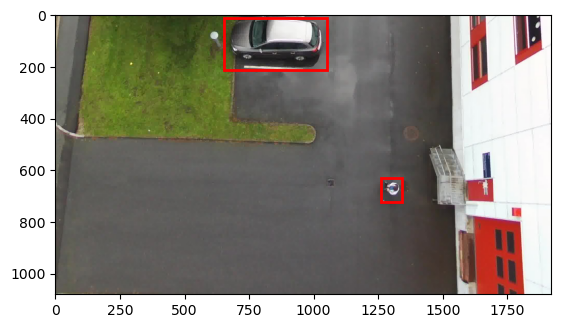

In [177]:
fig, ax = plt.subplots(1)


ax.imshow(img)

for i in range(100):
    
    rect = patches.Rectangle((all_bboxes[num][i][1], all_bboxes[num][i][0]), all_bboxes[num][i][3], all_bboxes[num][i][2], linewidth=2, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)

plt.show()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Small Dimensions</h2>
</div>

In [178]:
all_images,     all_bboxes    =    preprocess_annotations(annotations_ann)

100%|██████████| 32823/32823 [00:00<00:00, 142056.78it/s]


In [180]:
num  =  1

In [181]:
img     =   Image.open(all_images[num]).convert("RGB")

In [182]:
t       =    transforms.Resize((480, 640))

In [183]:
img2    =   t(img) 

In [184]:
first   =  1080 / 480

In [185]:
second  =  1920 / 640

In [92]:
all_images,     all_bboxes    =    preprocess_annotations(annotations_ann)

100%|██████████| 32823/32823 [00:00<00:00, 140227.67it/s]


In [186]:
all_bboxes[:,  :,  0]   =  all_bboxes[:,  :,  0] / first
all_bboxes[:,  :,  2]   =  all_bboxes[:,  :,  2] / first

all_bboxes[:,  :,  1]   =  all_bboxes[:,  :,  1] / second
all_bboxes[:,  :,  3]   =  all_bboxes[:,  :,  3] / second

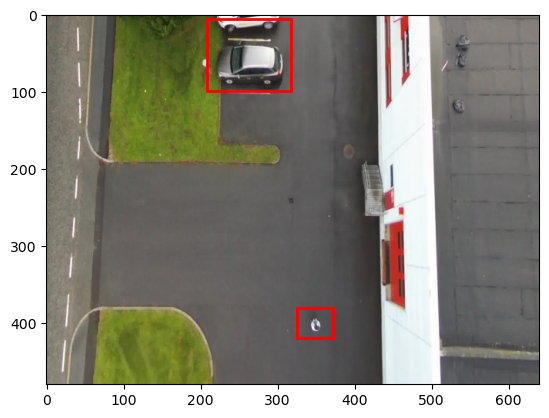

In [187]:
fig, ax = plt.subplots(1)


ax.imshow(img2)

for i in range(100):
    
    rect = patches.Rectangle((all_bboxes[num][i][1], all_bboxes[num][i][0]), all_bboxes[num][i][3], all_bboxes[num][i][2], linewidth=2, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)

plt.show()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Split Dataset according to the Report Paper </h2>
</div>

```python
annotations_train_val        =    all_bboxes[:30000,    :,  :]
annotations_test             =    all_bboxes[30000:-1,  :,  :] 
```

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Prepare Dataset for Training </h2>
</div>

In [188]:
class AUAIRDataset(Dataset):

    def __init__(self,  test = False,  transform=None):

        
        self.transform          =   transform 
        first                   =   1080 / 480
        second                  =   1920 / 640

        all_images,     all_bboxes    =    preprocess_annotations(annotations_ann) 

        all_bboxes[:,  :,  0]   =  all_bboxes[:,  :,  0] / first
        all_bboxes[:,  :,  2]   =  all_bboxes[:,  :,  2] / first 
        
        all_bboxes[:,  :,  1]   =  all_bboxes[:,  :,  1] / second
        all_bboxes[:,  :,  3]   =  all_bboxes[:,  :,  3] / second
        
        if test:

            self.annotations    =   all_bboxes[30000:-1,  :,  :]  
            self.img_paths      =   all_images[30000:-1] 

        else:

            self.annotations    =   all_bboxes[:30000,    :,  :]
            self.img_paths      =   all_images[:30000]  

    
    def __len__(self):
        
        return    len(self.annotations)  


    def __getitem__(self, idx):

        data          =     self.annotations[idx]   
        img_path      =     self.img_paths[idx]  
            
        image         =     Image.open(img_path).convert("RGB")   

                    
        
        if self.transform:
            
            image = self.transform(image) 
            

            image         =     np.array(image, dtype=np.float32)

        
        return     image,       data  



In [189]:
img_size   =   (480, 640) 

In [190]:
data_transform = transforms.Compose([
    
    transforms.Resize(img_size),  

])


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  For Training   </h2>
</div>

In [192]:
dataset      =   AUAIRDataset(    test=False,    transform  =  data_transform)

100%|██████████| 32823/32823 [00:00<00:00, 141473.73it/s]


In [193]:
len(dataset)

30000

In [194]:
train_size   =    int(0.9 * len(dataset))
val_size     =    len(dataset) - train_size 

In [195]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) 

In [196]:
train_loader   =   DataLoader(train_dataset, batch_size=32, num_workers  =   8,   pin_memory = True,    shuffle=True)
val_loader     =   DataLoader(val_dataset,   batch_size=32, num_workers  =   8,   pin_memory = True,    shuffle=True)   

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  For Testing (Unseen Data)   </h2>
</div>

In [197]:
#dataset2       =   AUAIRDataset(all_images,  all_bboxes,      test=True,    transform  =  data_transform)

In [198]:
#len(dataset2)

In [199]:
#test_loader   =   DataLoader(dataset2,  batch_size=16, num_workers  =   8,   pin_memory = True,   shuffle=True)

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Dimensions  </h2>
</div>

In [200]:
for i, j in train_loader:
    break

In [201]:
i.shape

torch.Size([32, 480, 640, 3])

In [202]:
j.shape

torch.Size([32, 100, 5])

In [213]:
num  =  4

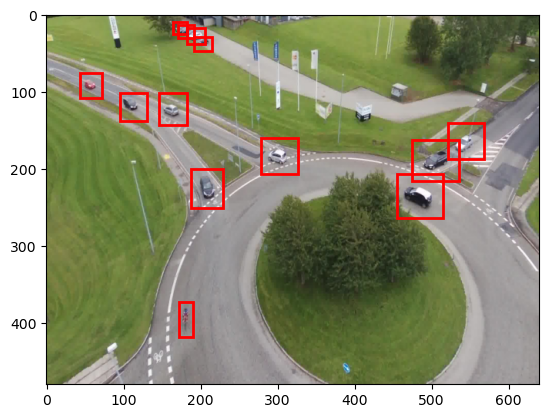

In [214]:
fig, ax = plt.subplots(1)


ax.imshow(i[num]/255.0)

for k in range(100):
    
    rect = patches.Rectangle((j[num][k][1], j[num][k][0]), j[num][k][3], j[num][k][2], linewidth=2, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)

plt.show()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:10px;">
<h2>  Model </h2>
</div>


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Patch Embeddings </h2>
</div>


In [215]:
class PatchEmbedding(nn.Module):
    
    def __init__(self, in_channels = 0, img_size= (0,0) , patch_size = 0, embed_dim = 0):
        
        self.patch_size  = patch_size
        self.num_patches = (img_size[0] // patch_size) * (img_size[1] // patch_size)
        
        super().__init__()
        
        self.projection = nn.Sequential(

            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            
            nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        
        return x

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  ResNET as Backbone </h2>
</div>

In [236]:
import torchvision.models as models

In [237]:
class ResNetBackbone(nn.Module):
    
    def __init__(self, embed_dim):
        super().__init__()
        self.resnet       =   models.resnet50(pretrained=True)
        self.resnet       =   nn.Sequential(*list(self.resnet.children())[:-2])
        self.projection   =   nn.Linear(2048, embed_dim)
        
    def forward(self, x: Tensor) -> Tensor:
        x                =   self.resnet(x)                      # B x 2048 x H' x W'
        B, C, H, W       =   x.shape
        x                =   x.view(B, C, H * W).permute(0, 2, 1)  # B x (H'*W') x 2048
        x                =   self.projection(x)                  # B x (H'*W') x embed_dim
        return x

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  ViT </h2>
</div>

In [256]:
class ViT(nn.Module):
    
    def __init__(self, ch=0, img_size=0,  num_classes=0, embed_dim=0, n_layers=0, mlp_ratio=0, dropout=0, heads=0, num_queries=0):
        
        super(ViT, self).__init__()

#---------------------------------------------------------------------------------------------------------------------------------------#
        
        self.patch_embedding  =   ResNetBackbone(embed_dim = embed_dim)

        for param in self.patch_embedding.parameters():
            param.requires_grad = False


        self.num_patches      =   (img_size[0] // 32) * (img_size[1] // 32)    #   num_patches = 15 × 20 = 300  
#---------------------------------------------------------------------------------------------------------------------------------------#
        #self.cls_token        =   nn.Parameter(torch.zeros(1, 1, embed_dim))
#---------------------------------------------------------------------------------------------------------------------------------------#        
        self.pos_embedding    =   nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))
#---------------------------------------------------------------------------------------------------------------------------------------#
        self.pos_drop         =   nn.Dropout(dropout)
#---------------------------------------------------------------------------------------------------------------------------------------#
        # Transformer Encoder
               
        encoder_layer = nn.TransformerEncoderLayer(d_model          =  embed_dim,
                                                   nhead            =  heads,
                                                   dim_feedforward  =  int(embed_dim * mlp_ratio),
                                                   dropout          =  dropout,
                                                   activation       =  'gelu',
                                                   batch_first      =  True)

        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

#---------------------------------------------------------------------------------------------------------------------------------------#
        
        self.query_embed      =   nn.Embedding(num_queries, embed_dim)
        
        # Transformer decoder
        
        decoder_layer = nn.TransformerDecoderLayer(d_model      =   embed_dim,
                                                   nhead        =   heads,
                                                   dropout      =   dropout,
                                                   activation   =   'gelu',
                                                   batch_first  =   True)
            
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=n_layers)
        
#---------------------------------------------------------------------------------------------------------------------------------------#
        
        # Prediction heads:
        # One head for bounding box regression: output 4 values (cx, cy, w, h) normalized to [0, 1].
        
        self.bbox_head        =   nn.Linear(embed_dim, 4) 
        
        # One head for classification: output probabilities for each class (plus 1 for "no object" if desired)
        self.class_head       =   nn.Linear(embed_dim, num_classes + 1)

#---------------------------------------------------------------------------------------------------------------------------------------#
        self.norm             =   nn.LayerNorm(embed_dim)
#---------------------------------------------------------------------------------------------------------------------------------------#
        # Initialize weights (a simple approach; for production consider a better init scheme).
        self._init_weights()
        
#---------------------------------------------------------------------------------------------------------------------------------------#        
        
    def _init_weights(self):

        nn.init.trunc_normal_(self.pos_embedding, std=0.02)
        
        nn.init.zeros_(self.bbox_head.bias)
        nn.init.trunc_normal_(self.bbox_head.weight, std=0.02)

        nn.init.zeros_(self.class_head.bias)
        nn.init.trunc_normal_(self.class_head.weight, std=0.02)
        
#---------------------------------------------------------------------------------------------------------------------------------------#        
        
    def forward(self, x):
        
        B = x.shape[0]
        
        x = self.patch_embedding(x)                           # B x num_patches x embed_dim
    
        if x.shape[1] != self.pos_embedding.shape[1]:
            pos_embed = nn.Parameter(torch.zeros(1, x.shape[1], x.shape[2]).to(x.device))
            nn.init.trunc_normal_(pos_embed, std=0.02)
        else:
            pos_embed = self.pos_embedding
    
        x = x + pos_embed
        x = self.pos_drop(x)
        x = self.transformer_encoder(x)
        x = self.norm(x)
    
        queries = self.query_embed.weight.unsqueeze(1).repeat(1, B, 1)
        decoded = self.decoder(tgt=queries.transpose(0, 1), memory=x)
    
        bbox_preds  = self.bbox_head(decoded).sigmoid()
        class_preds = self.class_head(decoded)
    
        return bbox_preds, class_preds


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Checking the Dimensions </h2>
</div>

In [257]:
if 1:
    m   =   ViT(ch=3, img_size=(480, 640), num_classes=8, embed_dim=768, n_layers=6, mlp_ratio=4, dropout=0.2, heads=8, num_queries=100)

In [258]:
if 1:
    dummy   =   torch.zeros(8, 3, 224, 224)

In [259]:
if 1:
    x       =  m.forward(dummy)  

In [260]:
if 1:
    print(x[0].shape),  print(x[1].shape)

torch.Size([8, 100, 4])
torch.Size([8, 100, 9])


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Employ GPU</h2>
</div>

In [261]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [262]:
device

device(type='cuda')

In [263]:
640 / 16

40.0

In [264]:
480 / 16

30.0

In [265]:
model   =  ViT(ch=3, img_size= (480, 640), num_classes=8, embed_dim=256, n_layers=6, mlp_ratio=4, dropout=0.2, heads=8, num_queries=100).to(device)

In [266]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of trainable parameters in the model:", num_params)

Number of trainable parameters in the model: 14317325


In [81]:
15 604 749

SyntaxError: invalid syntax (1561776530.py, line 1)

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  To Save Weights and Losses : </h2>
</div>

In [267]:
path_model   =  "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2/weights/Transformer_weight_1.pth"
path_losses  =  "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2/weights/Transformer_losses_1.pth"

In [268]:
if 1:
    
    torch.save({
            'model_state_dict': model.state_dict(),
            'best_loss'       : 9999999999999,
        }, path_model)   

In [269]:
if 1:
    
    torch.save({
        
            'train_loss'    : [],
            'val_loss'      : [], 
    
            'epochs'        : [],
    
        }, path_losses)    

In [270]:
if 1:
    
    checkpoint_weights   =   torch.load(path_model, weights_only=True) 
    checkpoint_losses    =   torch.load(path_losses, weights_only=True)  
    
    model.load_state_dict(checkpoint_weights['model_state_dict'])
    
    best_loss       =  checkpoint_weights['best_loss'] 
    train_loss      =  checkpoint_losses['train_loss']
    val_loss        =  checkpoint_losses['val_loss']
    
    epochs          =  checkpoint_losses['epochs'] 

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Training : </h2>
</div>

In [225]:
def train2(num_epochs=0, patience=0, counter=0, learning_rate=0,     best_loss=best_loss):
    

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    
    run.log({"LRate": learning_rate})  
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5) 
    scaler    = GradScaler()

    for epoch in range(num_epochs):
    
        model.train()
        
        total_loss_train = 0
        
        for batch in tqdm.tqdm(train_loader):
            
            inputs   =   batch["image"]
            labels   =   batch["bbox"]      #  top, left, height, width, class 
            
            inputs, labels = inputs.to(device), labels.to(device)
    
            optimizer.zero_grad()

            with autocast(device_type='cuda'):
                
                bbox_preds, class_preds = model(inputs)

                loss(labels["top"], )
                
            scaler.scale(loss).backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
            scaler.step(optimizer)
            scaler.update()
    
            total_loss_train += loss.item()

        total_loss_train     /= len(train_loader)

        train_loss.append(total_loss_train)
    

        # Log metrics to wandb.
        run.log({"Train Loss": total_loss_train})
    

        if torch.isnan(torch.tensor(total_loss_train)):
            print("NaN value encountered!")
            break

        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]          |        Total Train Loss : {total_loss_train:.4f}           |")
        print("-------------------------------------------------------------------------------")

#-----------------------------------------------------------------------------------------------

        
        model.eval()

        total_loss_val      =   0.0

        with torch.no_grad():
            for batch in tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):

                inputs   =   batch["input_ids"]
                labels   =   batch["labels"]
            
                inputs, labels = inputs.to(device), labels.to(device)
        

                logits, loss = model(inputs, labels)

                total_loss_val     += loss.item()

        total_loss_val     /= len(val_loader)

        val_loss.append(total_loss_val)

        run.log({"Val Loss": total_loss_val})

        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]         |       Total Validation Loss : {total_loss_val:.4f}           |")
        print("-------------------------------------------------------------------------------")

        
        if len(val_loss) >= 2:
            res = ((val_loss[-2] - val_loss[-1]) / val_loss[-2]) * 100
            print("-------------------------------------------------------------------------------")
            print(f"|              Change in loss is      %   {res:.2f}                               |")
            print("-------------------------------------------------------------------------------")

        if  total_loss_val < best_loss:
            
            print("*************...saving best model *************")
            
            best_loss = total_loss_val
            
            torch.save({
                'model_state_dict': model.state_dict(),
                'best_loss'       : best_loss,
            }, path_model)
             

        epochs.append(epoch)

        torch.save({
        
            'train_loss': train_loss,
            'val_loss': val_loss,
            'epochs': epochs,
        }, path_losses)

        if (len(val_loss) >= 2) and (val_loss[-2] > val_loss[-1]):
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping!")
                break

        scheduler.step()  
        torch.cuda.empty_cache()

In [274]:
def train(num_epochs=0, patience=0, counter=0, learning_rate=0, best_loss=best_loss):
    
    optimizer       =   AdamW(model.parameters(), lr=learning_rate)
    
    run.log({"LRate": learning_rate})  
    
    scheduler       =   torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5) 
    scaler          =   GradScaler()

    for epoch in range(num_epochs):
    
        model.train()
        
        total_loss_train   =   0
        
        for img, bbox in tqdm.tqdm(train_loader):
            
            img       =     img.to(device)
            bbox      =     bbox.to(device) 

            run.log({"Batch_size": img.shape[0]})   
    
            optimizer.zero_grad()

            with autocast(device_type='cuda'):
                
                bbox_preds, class_preds   =   model(img.view(-1, 3, 480, 640))
                gt_bbox                   =   bbox[:, :, :4]
                gt_class                  =   bbox[:, :, 4].long() 
                loss_bbox                 =   F.l1_loss(bbox_preds[gt_class != 9], gt_bbox[gt_class != 9], reduction='mean')
                loss_cls                  =   F.cross_entropy(class_preds.reshape(-1, class_preds.shape[-1]), gt_class.reshape(-1), ignore_index=9)
                loss                      =   loss_bbox + loss_cls
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
    
            total_loss_train   +=   loss.item()

        total_loss_train   /=   len(train_loader)

        train_loss.append(total_loss_train)
    
        run.log({"Train Loss": total_loss_train})
    
        if torch.isnan(torch.tensor(total_loss_train)):
            print("NaN value encountered!")
            break

        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]          |        Total Train Loss : {total_loss_train:.4f}           |")
        print("-------------------------------------------------------------------------------")

#-----------------------------------------------------------------------------------------------
        
        model.eval()

        total_loss_val   =   0.0

        with torch.no_grad():
            
            for img, bbox in tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):

                img       =     img.to(device)
                bbox      =     bbox.to(device) 
            
                with autocast(device_type='cuda'):
                    
                    bbox_preds, class_preds   =   model(img.view(-1, 3, 480, 640))
                    gt_bbox                   =   bbox[:, :, :4]
                    gt_class                  =   bbox[:, :, 4].long() 
                    loss_bbox                 =   F.l1_loss(bbox_preds[gt_class != 9], gt_bbox[gt_class != 9], reduction='mean')
                    loss_cls                  =   F.cross_entropy(class_preds.reshape(-1, class_preds.shape[-1]), gt_class.reshape(-1), ignore_index=9)
                    loss                      =   loss_bbox + loss_cls
    
                total_loss_val   +=   loss.item()

        total_loss_val   /=   len(val_loader)

        val_loss.append(total_loss_val)

        run.log({"Val Loss": total_loss_val})

        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]         |       Total Validation Loss : {total_loss_val:.4f}           |")
        print("-------------------------------------------------------------------------------")

        if len(val_loss) >= 2:
            res       =   ((val_loss[-2] - val_loss[-1]) / val_loss[-2]) * 100
            print("-------------------------------------------------------------------------------")
            print(f"|              Change in loss is      %   {res:.2f}                               |")
            print("-------------------------------------------------------------------------------")

        if total_loss_val < best_loss:
            
            print("*************...saving best model *************")
            
            best_loss       =   total_loss_val
            
            torch.save({
                'model_state_dict': model.state_dict(),
                'best_loss'       : best_loss,
            }, path_model)
             

        epochs.append(epoch)

        torch.save({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'epochs': epochs,
        }, path_losses)

        if (len(val_loss) >= 2) and (val_loss[-2] > val_loss[-1]):
            counter       =   0
        else:
            counter       +=   1
            if counter >= patience:
                print("Early stopping!")
                break

        scheduler.step()  
        torch.cuda.empty_cache()


In [275]:
torch.cuda.empty_cache()

In [ ]:
train(num_epochs=20, patience=5, counter=0, learning_rate=0.0001, best_loss=best_loss)

  2%|▏         | 15/844 [00:10<06:27,  2.14it/s]

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Accuracy Score on Unseen data : </h2>
</div>

In [ ]:
model  =  model.to(device)

model.eval()

all_preds, all_labels = [], []

for batch in tqdm.tqdm(test_loader):
        
    inputs   =   batch["input_ids"]
    labels   =   batch["labels"]
    
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        logits, _ = model(inputs)
        preds     = torch.argmax(logits, dim=1).cpu().numpy()

    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())


acc  =  accuracy_score(all_labels, all_preds)


print(f"Accuracy: {acc:.4f}")

#run.log({"acc": acc})

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Confusion Matrix</h2>
</div>

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Heatmap</h2>
</div>

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Sync for WANDB</h2>
</div>

In [ ]:
#run.finish() 